In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

from src.data.preprocess import data_preprocessing
from src.data.resample import data_resampling
from src.model.mlp import train_mlp 
from src.training.tune import run_random_search, generate_random_param_grid
from src.model.MLPClassifier import MLPClassifier
from src.visualization.plot_curves import best_threshold
from src.training.evaluate import evaluate_torch_model

In [5]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
labeled_path = os.path.join(parent_dir, "data", "data_final","labeled_data.csv")
labeled_data = pd.read_csv(labeled_path)

In [ ]:
# def preprocess_user_data(df, is_train=True, scaler=None, label_encoders=None):
#     df = df.copy()

#     for col in ['msno', 'registration_init_time']:
#         if col in df.columns:
#             df.drop(columns=col, inplace=True)

#     for col in ['last_login_date_previous', 'last_login_date_current']:
#         if col in df.columns:
#             df[col] = pd.to_datetime(df[col], errors='coerce')

#     if all(c in df.columns for c in ['last_login_date_current', 'last_login_date_previous']):
#         default_date = pd.to_datetime("1970-01-01")
#         df['days_until_month_end'] = ((df['last_login_date_current'] + pd.offsets.MonthEnd(0)) - df['last_login_date_current']).dt.days
#         df['last_login_interval'] = (df['last_login_date_current'] - df['last_login_date_previous']).dt.days

#         curr_is_default = df['last_login_date_current'] == default_date
#         prev_is_default = df['last_login_date_previous'] == default_date
#         both_default = curr_is_default & prev_is_default

#         df.loc[curr_is_default & ~both_default, 'days_until_month_end'] = 45
#         df.loc[curr_is_default & ~both_default, 'last_login_interval'] = df.loc[curr_is_default & ~both_default].apply(
#             lambda row: 45 + (calendar.monthrange(row['last_login_date_previous'].year, row['last_login_date_previous'].month)[1] - row['last_login_date_previous'].day)
#             if row['last_login_date_previous'] != default_date else 90,
#             axis=1
#         )
#         df.loc[prev_is_default & ~both_default, 'days_until_month_end'] = 45
#         df.loc[prev_is_default & ~both_default, 'last_login_interval'] = df.loc[prev_is_default & ~both_default].apply(
#             lambda row: 45 + calendar.monthrange(row['last_login_date_current'].year, row['last_login_date_current'].month)[1]
#             if row['last_login_date_current'] != default_date else 90,
#             axis=1
#         )
#         df.loc[both_default, 'days_until_month_end'] = 90
#         df.loc[both_default, 'last_login_interval'] = 90

#         for col in ['last_login_date_previous', 'last_login_date_current']:
#             if col in df.columns:
#                 df.drop(columns=col, inplace=True)

#     cat_cols = ['gender', 'city', 'registered_via']
#     fitted_label_encoders = {}
#     for col in cat_cols:
#         if col in df.columns:
#             df[col] = df[col].astype(str)
#             if is_train:
#                 le = LabelEncoder()
#                 df[col] = le.fit_transform(df[col])
#                 fitted_label_encoders[col] = le
#             else:
#                 le = label_encoders[col]
#                 df[col] = le.transform(df[col])

#     if is_train:
#         y = torch.tensor(df['is_churn'].astype(int).values, dtype=torch.float32)
#         df.drop(columns=['is_churn'], inplace=True)
#     else:
#         y = None
#         df.drop(columns=['is_churn'], inplace=True)

#     if is_train:
#         scaler = StandardScaler()
#         X_scaled = scaler.fit_transform(df)
#     else:
#         X_scaled = scaler.transform(df)

#     X_scaled = torch.tensor(X_scaled, dtype=torch.float32)  # ✅ 转为Tensor

#     return (X_scaled, y, scaler, fitted_label_encoders) if is_train else X_scaled


In [6]:
X_labeled, y, scaler, fitted_label_encoders = data_preprocessing(labeled_data, is_train=True, scaler=None, label_encoders=None)

X_train, X_test, y_train, y_test = train_test_split(
    X_labeled, y, test_size=0.2, random_state=42, stratify=y)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.astype(int).values, dtype=torch.float32)

In [13]:
X_train_resampled, y_train_resampled = data_resampling(X_train, y_train)

X_train_resampled = torch.tensor(X_train_resampled.values, dtype=torch.float32)
y_train_resampled = torch.tensor(y_train_resampled.astype(int).values, dtype=torch.float32)

In [ ]:
# def resample_smote_then_downsample(X, y, downsample_ratio=1.0):
#     sm = SMOTE(random_state=42)
#     X_res, y_res = sm.fit_resample(X.cpu().numpy(), y.cpu().numpy())

#     df = pd.DataFrame(X_res)
#     df['label'] = y_res
#     majority = df[df['label'] == 0]
#     minority = df[df['label'] == 1]
#     majority_down = majority.sample(n=int(len(minority) * downsample_ratio), random_state=42)
#     df_resampled = pd.concat([majority_down, minority], axis=0).sample(frac=1, random_state=42)

#     X_final = torch.tensor(df_resampled.drop(columns='label').values, dtype=torch.float32)
#     y_final = torch.tensor(df_resampled['label'].values, dtype=torch.float32)
#     return X_final, y_final

In [ ]:
# class MLPClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dims, dropout_rate=0.3):
#         super(MLPClassifier, self).__init__()
#         layers = []
#         last_dim = input_dim
#         for h_dim in hidden_dims:
#             layers.append(nn.Linear(last_dim, h_dim))
#             layers.append(nn.ReLU())
#             layers.append(nn.Dropout(dropout_rate))
#             last_dim = h_dim
#         layers.append(nn.Linear(last_dim, 1))
#         self.model = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.model(x).squeeze()

#     def reset_weights(self):
#         for layer in self.model:
#             if hasattr(layer, 'reset_parameters'):
#                 layer.reset_parameters()


In [ ]:
# def train_model(model, train_loader, val_loader, threshold=0.5, epochs=30, lr=0.001, patience=5,
#                 device=torch.device("cpu"), return_logs=False, log_path=None):

#     model = model
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     criterion = nn.BCEWithLogitsLoss() 
#     best_val_loss = float('inf')
#     best_model_state = None
#     no_improve_epochs = 0
#     logs = {'train_loss': [], 'val_loss': [], 'val_f1': []}

#     for epoch in tqdm(range(epochs), desc="Training Epochs"):
#         model.train()
#         train_losses = []
#         for X_batch, y_batch in train_loader:
#             X_batch = X_batch.to(device, non_blocking=True)
#             y_batch = y_batch.to(device, non_blocking=True)
#             optimizer.zero_grad()
#             outputs = model(X_batch)
#             loss = criterion(outputs, y_batch)
#             loss.backward()
#             optimizer.step()
#             train_losses.append(loss.item())

#         model.eval()
#         val_losses, y_true, y_pred = [], [], []
#         with torch.no_grad():
#             for X_val, y_val in val_loader:
#                 X_val = X_val.to(device, non_blocking=True)
#                 y_val = y_val.to(device, non_blocking=True)
#                 outputs = model(X_val)
#                 loss = criterion(outputs, y_val)
#                 val_losses.append(loss.item())
#                 preds = (torch.sigmoid(outputs) >= threshold).int()
#                 y_pred.append(preds.cpu())
#                 y_true.append(y_val.cpu())

#         y_true = torch.cat(y_true).numpy()
#         y_pred = torch.cat(y_pred).numpy()
#         val_loss = np.mean(val_losses)
#         f1 = f1_score(y_true, y_pred, zero_division=0)
#         logs['train_loss'].append(np.mean(train_losses))
#         logs['val_loss'].append(val_loss)
#         logs['val_f1'].append(f1)

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             best_model_state = model.state_dict()
#             no_improve_epochs = 0
#         else:
#             no_improve_epochs += 1
#             if no_improve_epochs >= patience:
#                 break

#     model.load_state_dict(best_model_state)
#     if log_path:
#         pd.DataFrame(logs).to_csv(log_path, index=False)
#     return (model, logs) if return_logs else model


In [ ]:
# def run_random_search(X, y, param_grid, k=3, epochs=30, batch_size=256, patience=5, device='cpu'):
#     best_params, best_avg_f1, best_model = None, -1, None
#     results = []
#     skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

#     for params in param_grid:
#         hidden_dims = params['hidden_dims']
#         lr = params['lr']
#         dropout = params['dropout']
#         threshold = 0.5
#         fold_f1_scores = []
#         best_f1_for_params = -1
#         print(f"\nTesting params: hidden_dims={hidden_dims}, lr={lr}, dropout={dropout}, threshold={threshold}")

#         model = MLPClassifier(input_dim=X.shape[1], hidden_dims=hidden_dims, dropout_rate=dropout)

#         fold_accuracies, fold_precisions, fold_recalls = [], [], []

#         for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
#             model.reset_weights()
#             X_tr, X_val = X[train_idx], X[val_idx]
#             y_tr, y_val = y[train_idx], y[val_idx]

#             train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
#             val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

#             model, logs = train_mlp(model, train_loader, val_loader, threshold=threshold,
#                                    epochs=epochs, lr=lr, patience=patience, device=device, return_logs=True)

#             plt.figure(figsize=(8, 5))
#             plt.plot(logs['train_loss'], label='Train Loss')
#             plt.plot(logs['val_loss'], label='Val Loss')
#             plt.plot(logs['val_f1'], label='Val F1')
#             plt.xlabel('Epoch')
#             plt.ylabel('Loss / F1')
#             plt.title(f'Fold {fold} Training Curve')
#             plt.legend()
#             plt.tight_layout()
#             plt.show()


#             model.eval()
#             y_preds = []
#             with torch.no_grad():
#                 for X_batch, _ in val_loader:
#                     X_batch = X_batch.to(device, non_blocking=True)
#                     preds = (torch.sigmoid(model(X_batch)) >= threshold).int()
#                     y_preds.append(preds.cpu())

#             y_val_np = y_val.cpu().numpy()
#             y_pred_np = torch.cat(y_preds).numpy()
#             f1 = f1_score(y_val_np, y_pred_np)
#             accuracy = accuracy_score(y_val_np, y_pred_np)
#             precision = precision_score(y_val_np, y_pred_np, zero_division=0)
#             recall = recall_score(y_val_np, y_pred_np, zero_division=0)

#             print(f"Fold {fold} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

#             fold_f1_scores.append(f1)
#             fold_accuracies.append(accuracy)
#             fold_precisions.append(precision)
#             fold_recalls.append(recall)

#             best_f1_for_params = max(best_f1_for_params, f1)

#         avg_f1 = np.mean(fold_f1_scores)
#         avg_accuracy = np.mean(fold_accuracies)
#         avg_precision = np.mean(fold_precisions)
#         avg_recall = np.mean(fold_recalls)

#         results.append((params, avg_f1))

#         print(f"🔹 Avg Accuracy: {avg_accuracy:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}")

#         if avg_f1 > best_avg_f1:
#             best_avg_f1 = avg_f1
#             best_params = params
#             best_model = MLPClassifier(input_dim=X.shape[1], hidden_dims=hidden_dims, dropout_rate=dropout)
#             best_model.load_state_dict(model.state_dict())

#     return best_params, results


In [ ]:
# def generate_random_param_grid(n_samples=6):
#     hidden_dims_choices = [[128, 64], [512, 256], [256, 128, 64]]
#     lr_choices = [0.0001, 0.0005, 0.001]
#     dropout_choices=[0.1,0.2,0.3]
#     grid = []
#     for _ in range(n_samples):
#         grid.append({
#             'hidden_dims': random.choice(hidden_dims_choices),
#             'lr': random.choice(lr_choices),
#             'dropout': random.choice(dropout_choices),
#         })
#     print("Generated Parameter Grid:")
#     for i, params in enumerate(grid, 1):
#         print(f"{i}. hidden_dims: {params['hidden_dims']}, lr: {params['lr']}, dropout: {params['dropout']}")
    
#     return grid



In [9]:

# Run Random Search
param_grid = generate_random_param_grid(12)


Generated Parameter Grid:
1. hidden_dims: [256, 128, 64], lr: 0.0005, dropout: 0.3
2. hidden_dims: [256, 128, 64], lr: 0.0005, dropout: 0.2
3. hidden_dims: [512, 256], lr: 0.0001, dropout: 0.1
4. hidden_dims: [128, 64], lr: 0.0005, dropout: 0.2
5. hidden_dims: [128, 64], lr: 0.0001, dropout: 0.1
6. hidden_dims: [128, 64], lr: 0.0005, dropout: 0.2
7. hidden_dims: [256, 128, 64], lr: 0.0001, dropout: 0.2
8. hidden_dims: [256, 128, 64], lr: 0.0005, dropout: 0.2
9. hidden_dims: [256, 128, 64], lr: 0.0005, dropout: 0.3
10. hidden_dims: [256, 128, 64], lr: 0.001, dropout: 0.2
11. hidden_dims: [512, 256], lr: 0.0005, dropout: 0.2
12. hidden_dims: [512, 256], lr: 0.0001, dropout: 0.3



Testing params: hidden_dims=[128, 64], lr=0.001, dropout=0.3, threshold=0.5


Training Epochs: 100%|██████████| 20/20 [04:53<00:00, 14.67s/it]


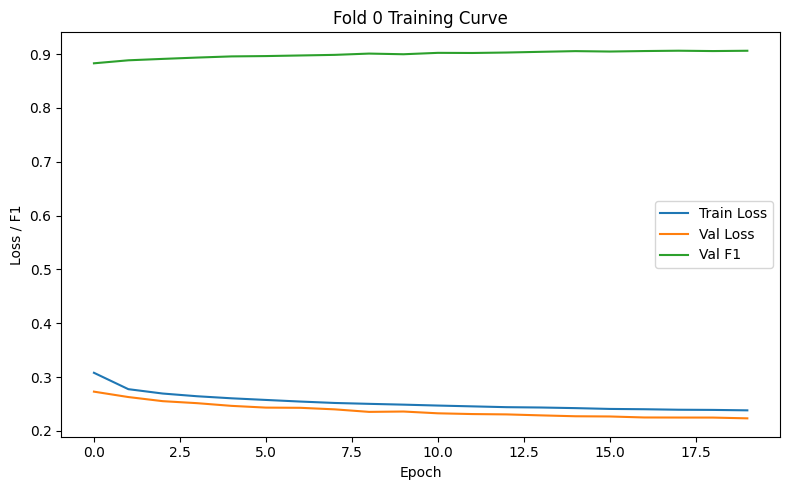

Fold 0 - Accuracy: 0.9051, Precision: 0.8968, Recall: 0.9156, F1: 0.9061


Training Epochs: 100%|██████████| 20/20 [06:22<00:00, 19.13s/it]


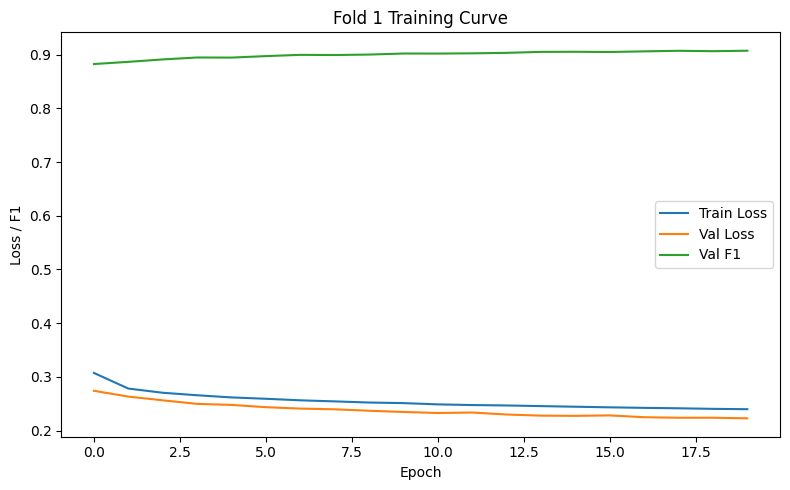

Fold 1 - Accuracy: 0.9051, Precision: 0.8868, Recall: 0.9287, F1: 0.9072


Training Epochs: 100%|██████████| 20/20 [08:47<00:00, 26.36s/it]


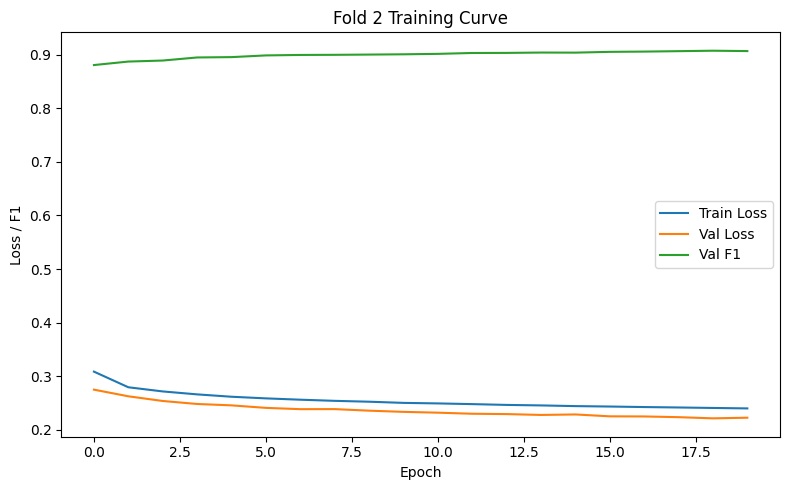

Fold 2 - Accuracy: 0.9053, Precision: 0.8950, Recall: 0.9184, F1: 0.9065
🔹 Avg Accuracy: 0.9052, Precision: 0.8929, Recall: 0.9209, F1: 0.9066

Testing params: hidden_dims=[256, 128, 64], lr=0.0005, dropout=0.2, threshold=0.5


Training Epochs: 100%|██████████| 20/20 [09:16<00:00, 27.84s/it]


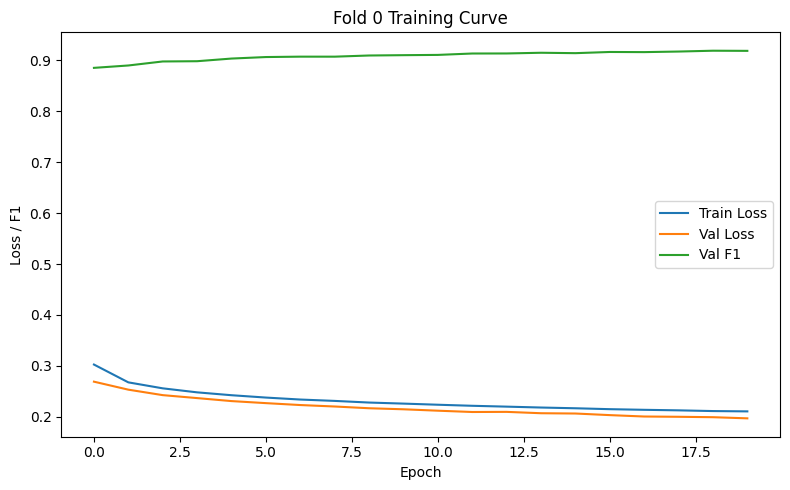

Fold 0 - Accuracy: 0.9178, Precision: 0.9074, Recall: 0.9306, F1: 0.9188


Training Epochs: 100%|██████████| 20/20 [10:28<00:00, 31.43s/it]


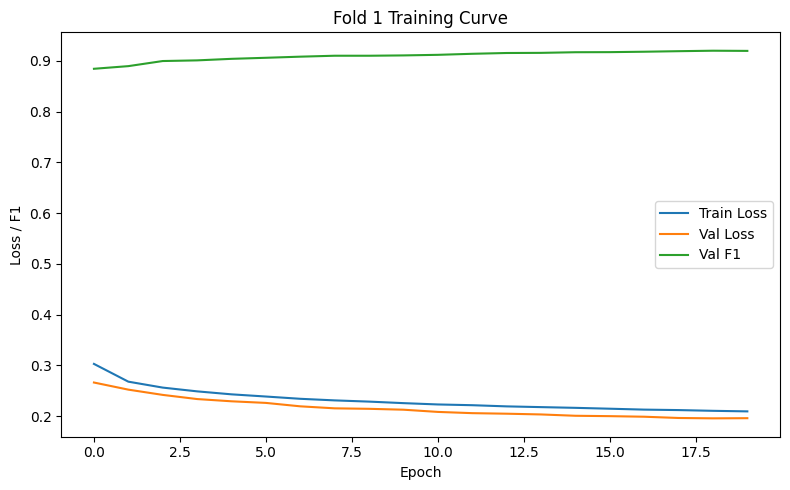

Fold 1 - Accuracy: 0.9180, Precision: 0.9038, Recall: 0.9356, F1: 0.9194


Training Epochs: 100%|██████████| 20/20 [08:50<00:00, 26.51s/it]


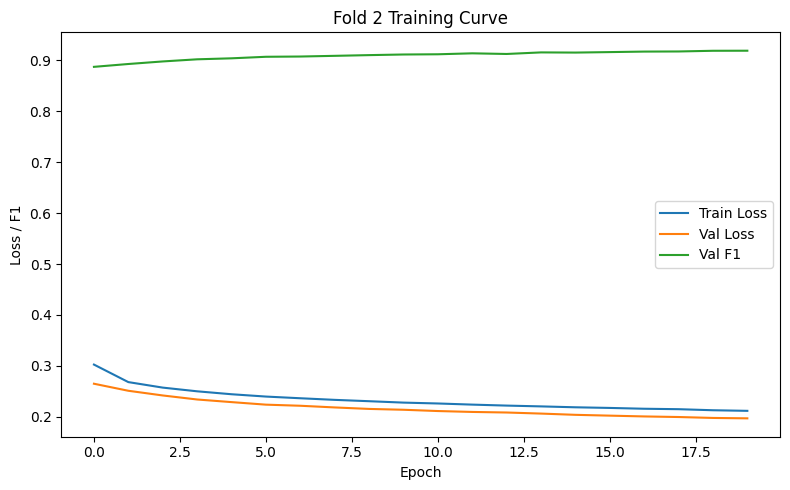

Fold 2 - Accuracy: 0.9176, Precision: 0.9068, Recall: 0.9309, F1: 0.9187
🔹 Avg Accuracy: 0.9178, Precision: 0.9060, Recall: 0.9324, F1: 0.9190

Testing params: hidden_dims=[512, 256], lr=0.001, dropout=0.2, threshold=0.5


Training Epochs: 100%|██████████| 20/20 [08:13<00:00, 24.66s/it]


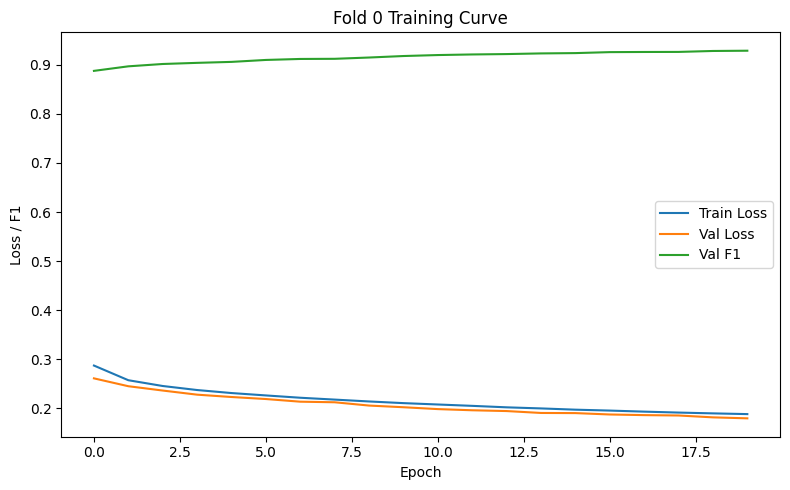

Fold 0 - Accuracy: 0.9274, Precision: 0.9126, Recall: 0.9454, F1: 0.9287


Training Epochs: 100%|██████████| 20/20 [10:55<00:00, 32.76s/it]


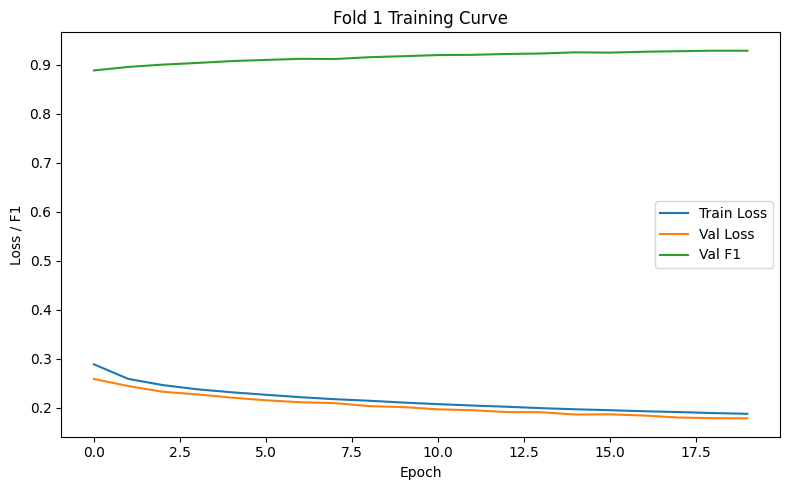

Fold 1 - Accuracy: 0.9277, Precision: 0.9121, Recall: 0.9467, F1: 0.9291


Training Epochs: 100%|██████████| 20/20 [11:20<00:00, 34.05s/it]


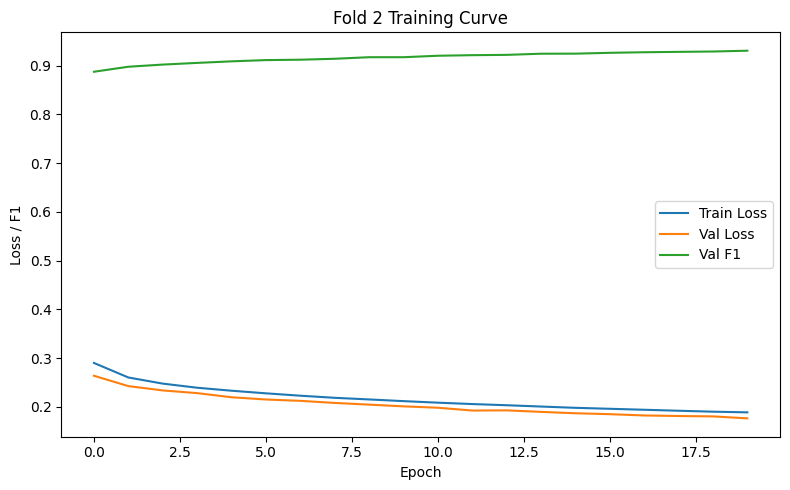

Fold 2 - Accuracy: 0.9289, Precision: 0.9097, Recall: 0.9525, F1: 0.9306
🔹 Avg Accuracy: 0.9280, Precision: 0.9115, Recall: 0.9482, F1: 0.9295

Testing params: hidden_dims=[256, 128, 64], lr=0.0005, dropout=0.2, threshold=0.5


Training Epochs: 100%|██████████| 20/20 [07:18<00:00, 21.93s/it]


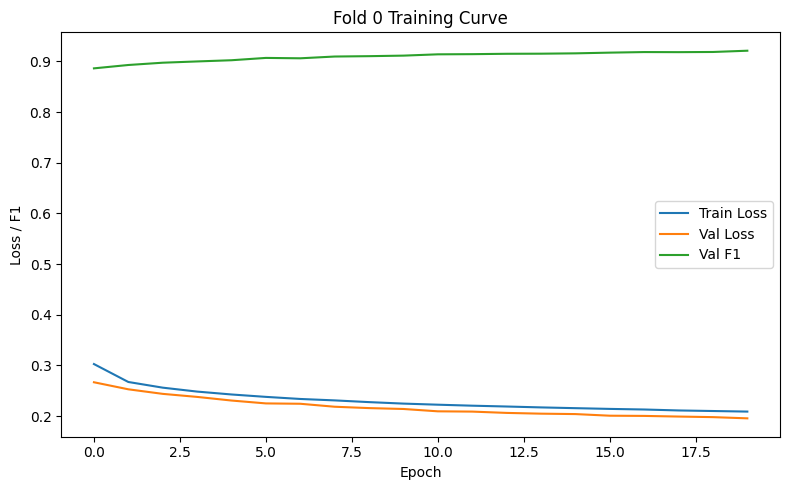

Fold 0 - Accuracy: 0.9194, Precision: 0.9029, Recall: 0.9398, F1: 0.9210


Training Epochs: 100%|██████████| 20/20 [06:07<00:00, 18.38s/it]


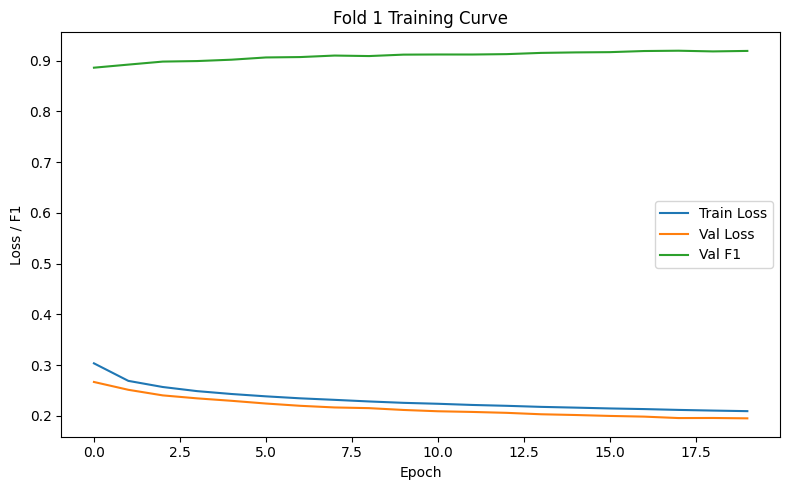

Fold 1 - Accuracy: 0.9187, Precision: 0.9116, Recall: 0.9274, F1: 0.9194


Training Epochs: 100%|██████████| 20/20 [06:05<00:00, 18.28s/it]


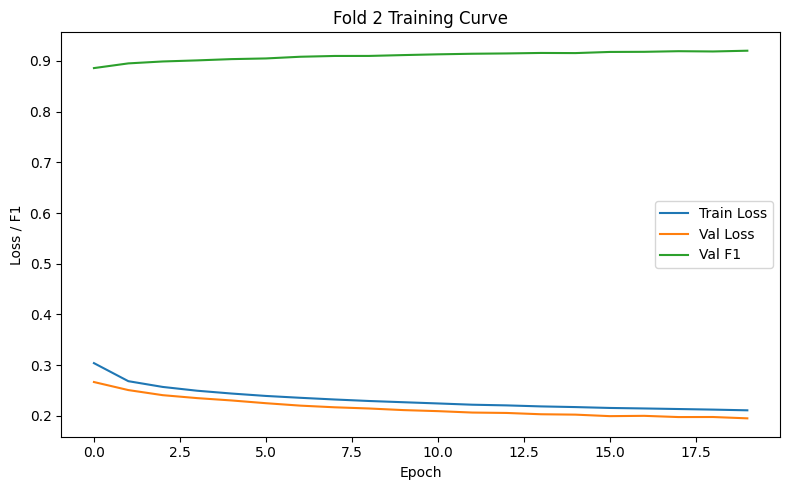

Fold 2 - Accuracy: 0.9184, Precision: 0.9007, Recall: 0.9405, F1: 0.9202
🔹 Avg Accuracy: 0.9188, Precision: 0.9051, Recall: 0.9359, F1: 0.9202

Testing params: hidden_dims=[256, 128, 64], lr=0.001, dropout=0.3, threshold=0.5


Training Epochs: 100%|██████████| 20/20 [07:21<00:00, 22.06s/it]


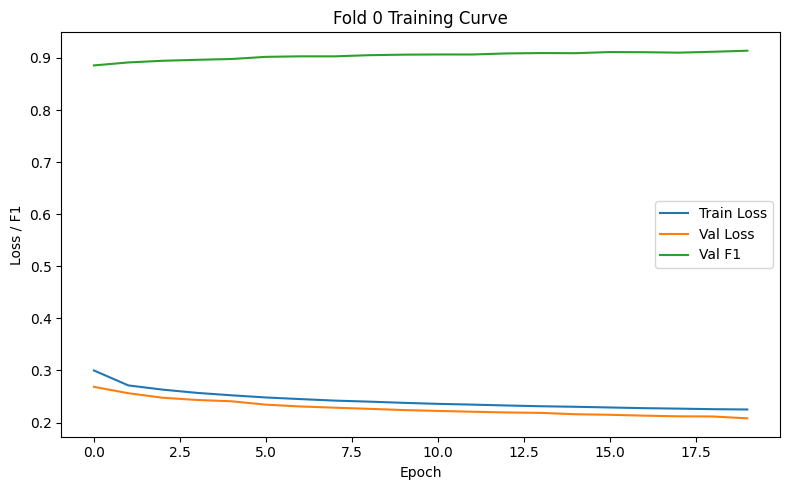

Fold 0 - Accuracy: 0.9127, Precision: 0.9021, Recall: 0.9259, F1: 0.9139


Training Epochs: 100%|██████████| 20/20 [10:36<00:00, 31.83s/it]


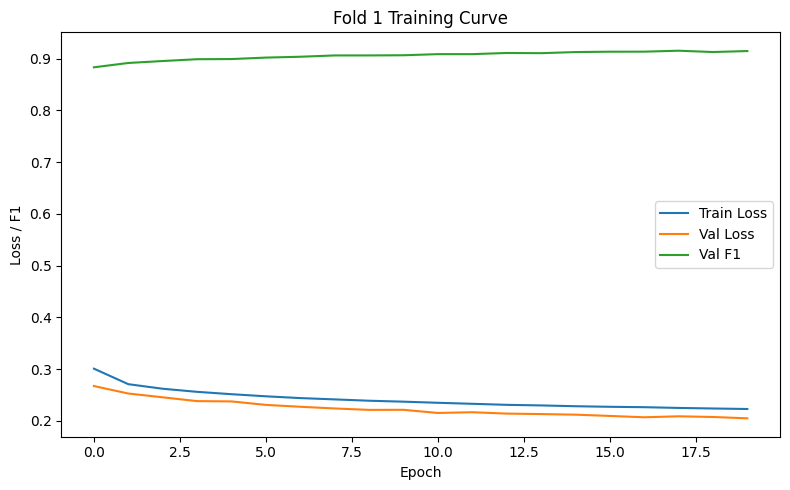

Fold 1 - Accuracy: 0.9137, Precision: 0.9056, Recall: 0.9237, F1: 0.9145


Training Epochs: 100%|██████████| 20/20 [10:11<00:00, 30.59s/it]


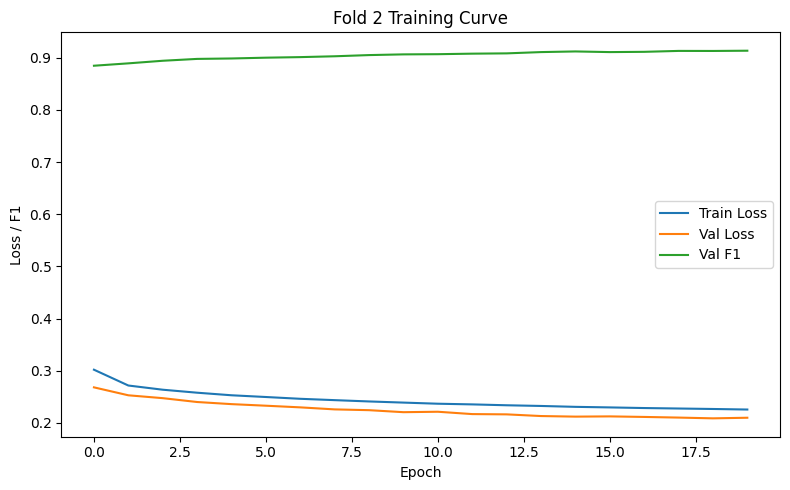

Fold 2 - Accuracy: 0.9131, Precision: 0.9074, Recall: 0.9200, F1: 0.9137
🔹 Avg Accuracy: 0.9132, Precision: 0.9050, Recall: 0.9232, F1: 0.9140

Testing params: hidden_dims=[512, 256], lr=0.0001, dropout=0.2, threshold=0.5


Training Epochs: 100%|██████████| 20/20 [12:25<00:00, 37.28s/it]


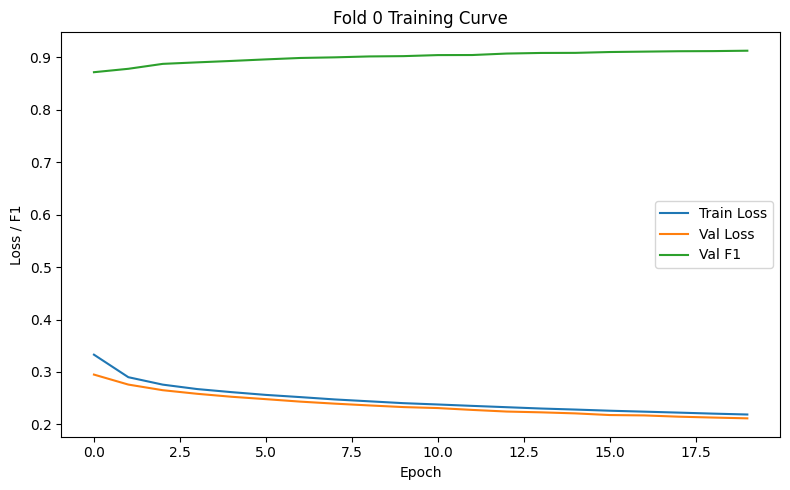

Fold 0 - Accuracy: 0.9111, Precision: 0.8970, Recall: 0.9288, F1: 0.9126


Training Epochs: 100%|██████████| 20/20 [13:06<00:00, 39.31s/it]


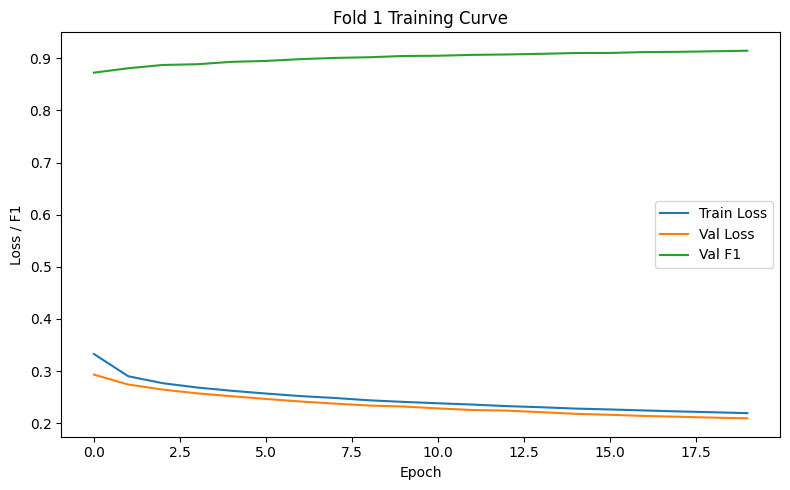

Fold 1 - Accuracy: 0.9125, Precision: 0.8945, Recall: 0.9353, F1: 0.9145


Training Epochs: 100%|██████████| 20/20 [12:49<00:00, 38.47s/it]


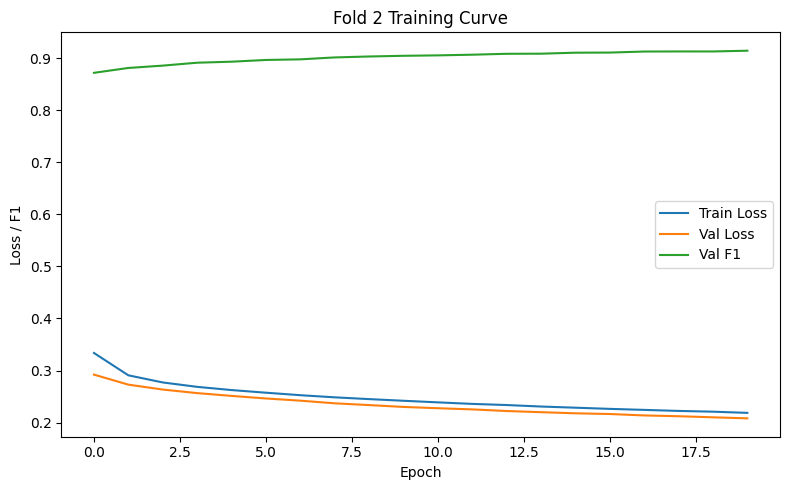

Fold 2 - Accuracy: 0.9134, Precision: 0.9034, Recall: 0.9258, F1: 0.9144
🔹 Avg Accuracy: 0.9123, Precision: 0.8983, Recall: 0.9300, F1: 0.9139

Testing params: hidden_dims=[256, 128, 64], lr=0.001, dropout=0.3, threshold=0.5


Training Epochs: 100%|██████████| 20/20 [10:39<00:00, 31.97s/it]


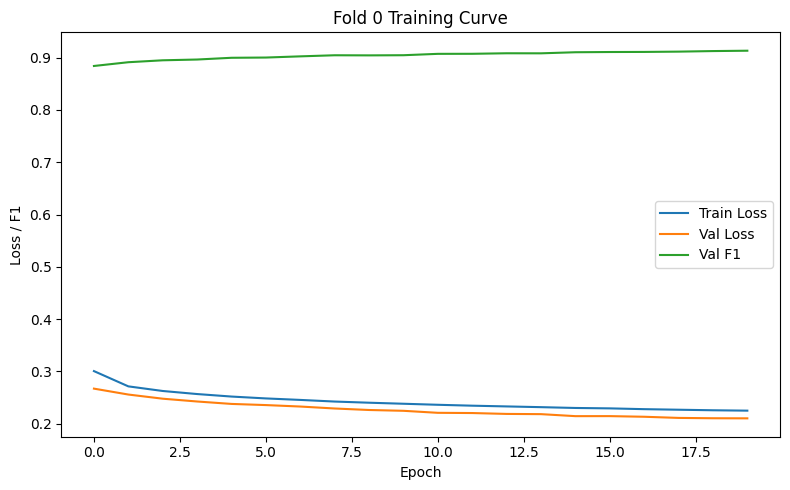

Fold 0 - Accuracy: 0.9120, Precision: 0.8999, Recall: 0.9272, F1: 0.9133


Training Epochs: 100%|██████████| 20/20 [07:54<00:00, 23.70s/it]


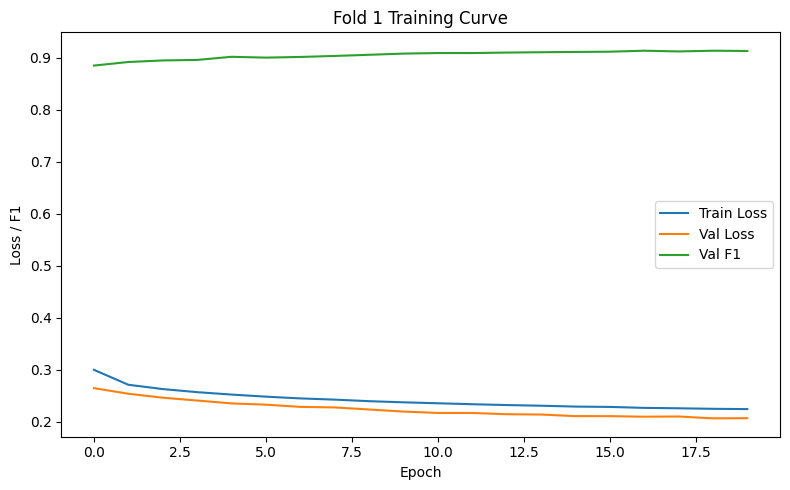

Fold 1 - Accuracy: 0.9123, Precision: 0.9073, Recall: 0.9185, F1: 0.9128


Training Epochs: 100%|██████████| 20/20 [07:22<00:00, 22.12s/it]


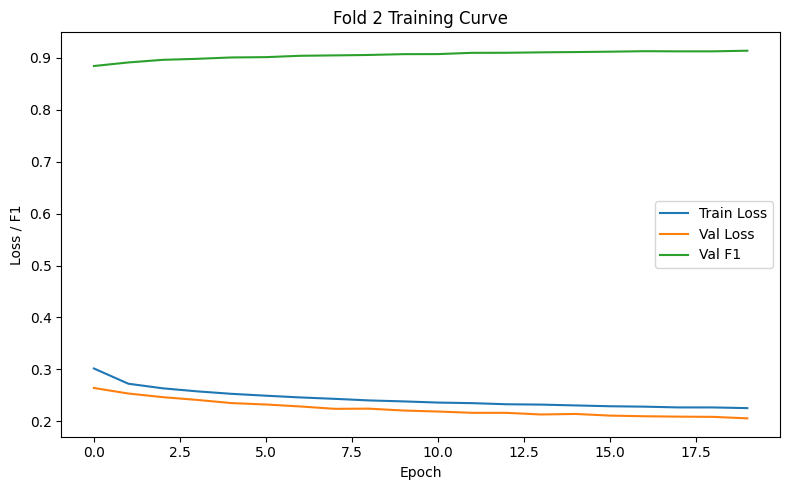

Fold 2 - Accuracy: 0.9125, Precision: 0.9017, Recall: 0.9260, F1: 0.9137
🔹 Avg Accuracy: 0.9123, Precision: 0.9029, Recall: 0.9239, F1: 0.9133

Testing params: hidden_dims=[256, 128, 64], lr=0.001, dropout=0.2, threshold=0.5


Training Epochs: 100%|██████████| 20/20 [06:09<00:00, 18.46s/it]


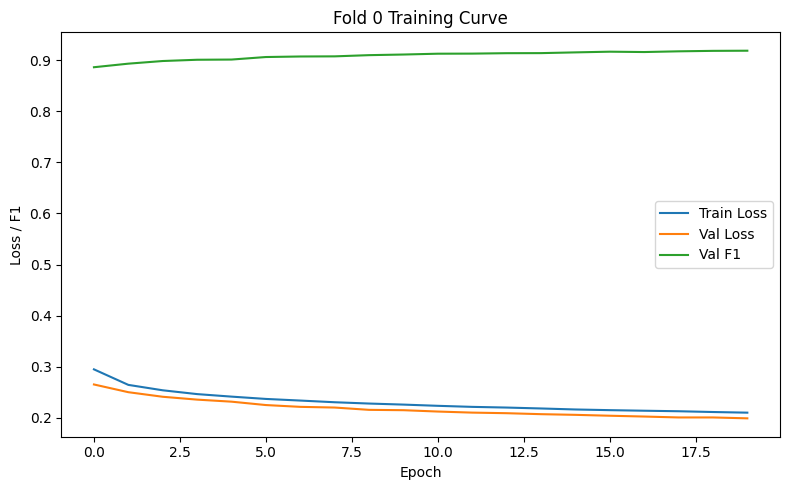

Fold 0 - Accuracy: 0.9169, Precision: 0.9031, Recall: 0.9340, F1: 0.9183


Training Epochs: 100%|██████████| 20/20 [05:47<00:00, 17.38s/it]


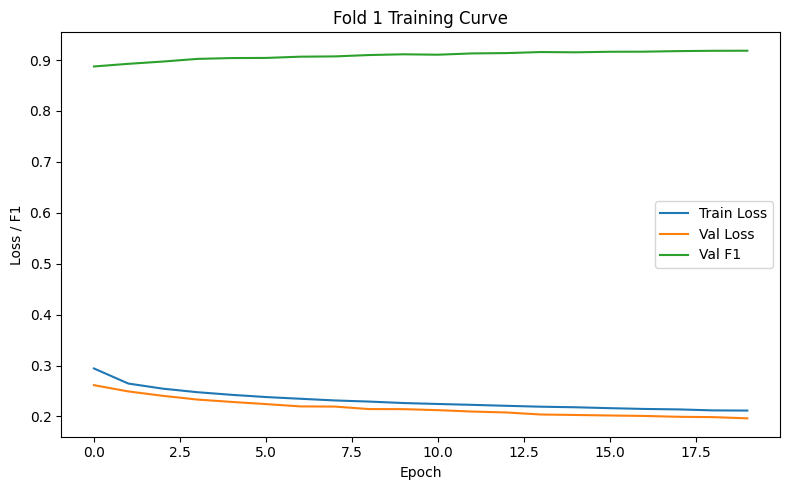

Fold 1 - Accuracy: 0.9177, Precision: 0.9110, Recall: 0.9259, F1: 0.9184


Training Epochs: 100%|██████████| 20/20 [07:20<00:00, 22.03s/it]


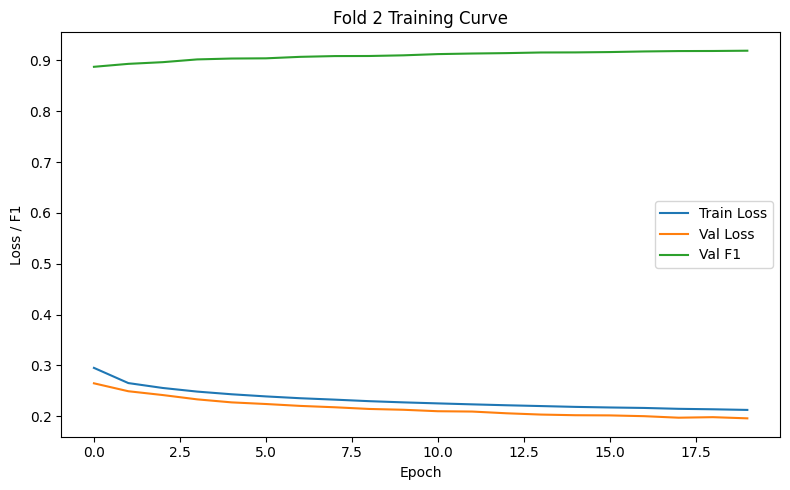

Fold 2 - Accuracy: 0.9183, Precision: 0.9087, Recall: 0.9299, F1: 0.9192
🔹 Avg Accuracy: 0.9176, Precision: 0.9076, Recall: 0.9299, F1: 0.9186

Testing params: hidden_dims=[512, 256], lr=0.001, dropout=0.1, threshold=0.5


Training Epochs: 100%|██████████| 20/20 [10:37<00:00, 31.87s/it]


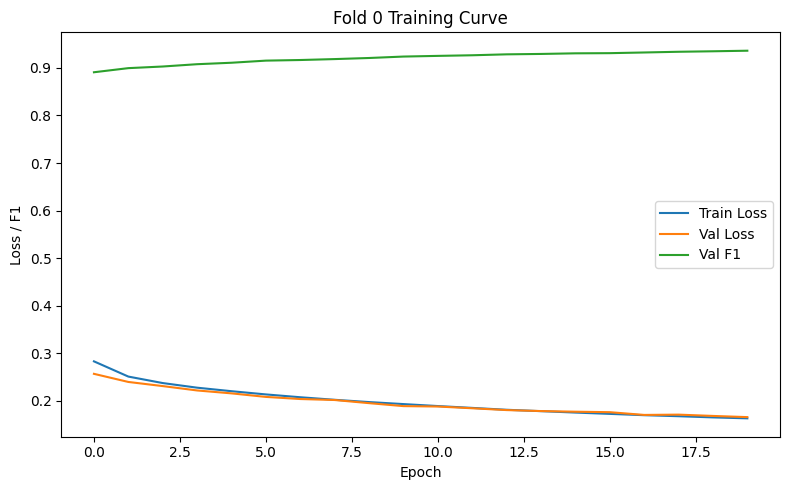

Fold 0 - Accuracy: 0.9348, Precision: 0.9168, Recall: 0.9565, F1: 0.9362


Training Epochs: 100%|██████████| 20/20 [10:47<00:00, 32.39s/it]


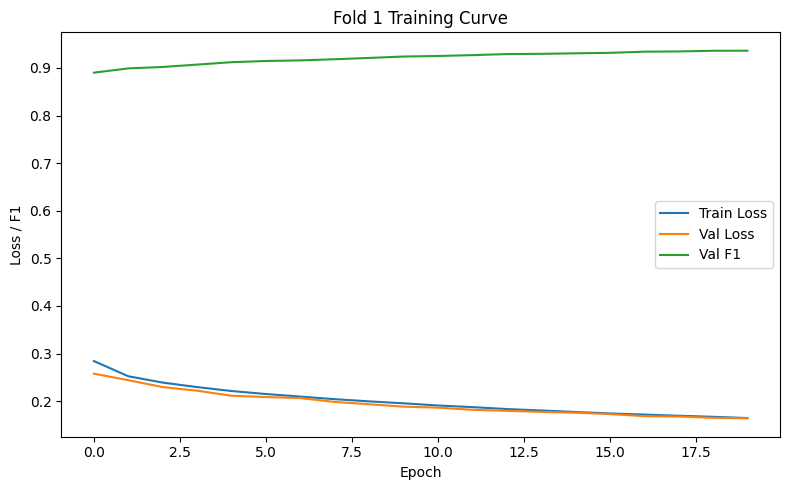

Fold 1 - Accuracy: 0.9350, Precision: 0.9190, Recall: 0.9541, F1: 0.9363


Training Epochs: 100%|██████████| 20/20 [10:29<00:00, 31.46s/it]


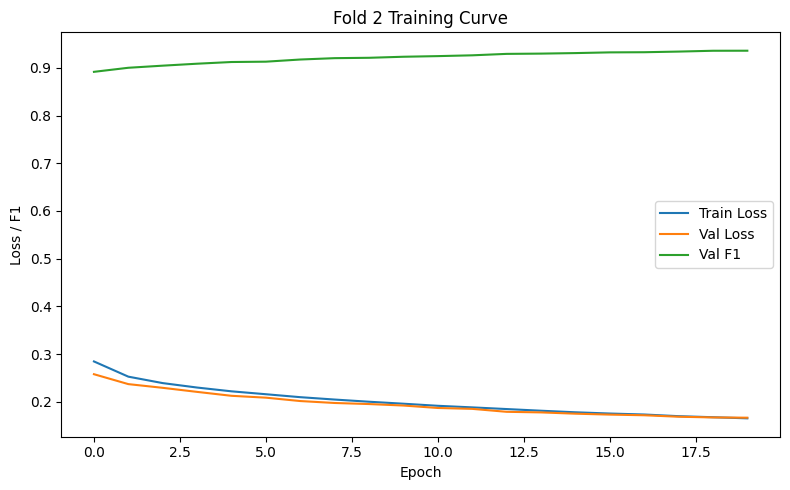

Fold 2 - Accuracy: 0.9342, Precision: 0.9119, Recall: 0.9612, F1: 0.9359
🔹 Avg Accuracy: 0.9347, Precision: 0.9159, Recall: 0.9573, F1: 0.9361

Testing params: hidden_dims=[512, 256], lr=0.001, dropout=0.3, threshold=0.5


Training Epochs: 100%|██████████| 20/20 [09:33<00:00, 28.68s/it]


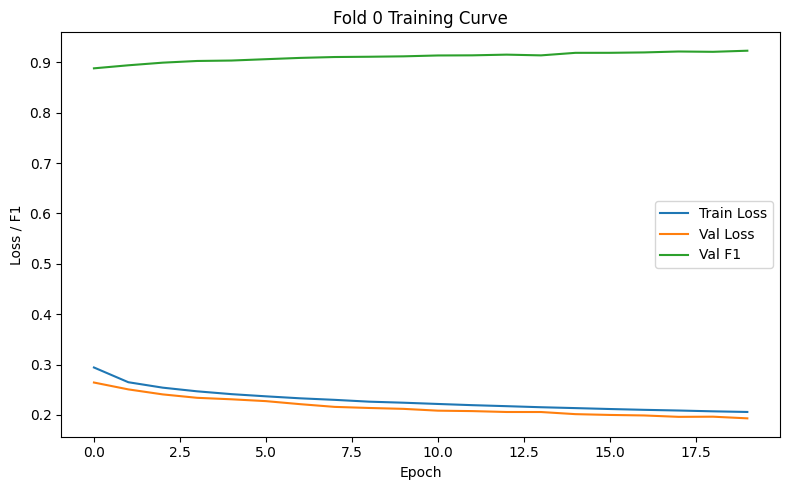

Fold 0 - Accuracy: 0.9215, Precision: 0.9036, Recall: 0.9436, F1: 0.9232


Training Epochs: 100%|██████████| 20/20 [10:47<00:00, 32.38s/it]


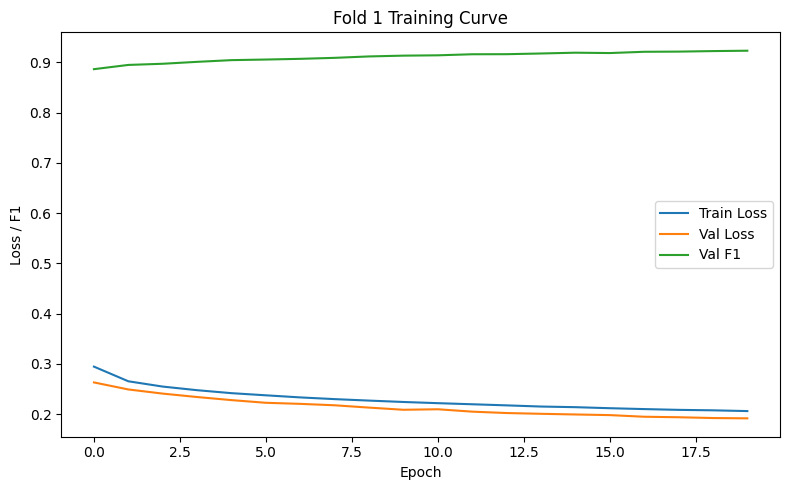

Fold 1 - Accuracy: 0.9218, Precision: 0.9078, Recall: 0.9389, F1: 0.9231


Training Epochs: 100%|██████████| 20/20 [09:09<00:00, 27.45s/it]


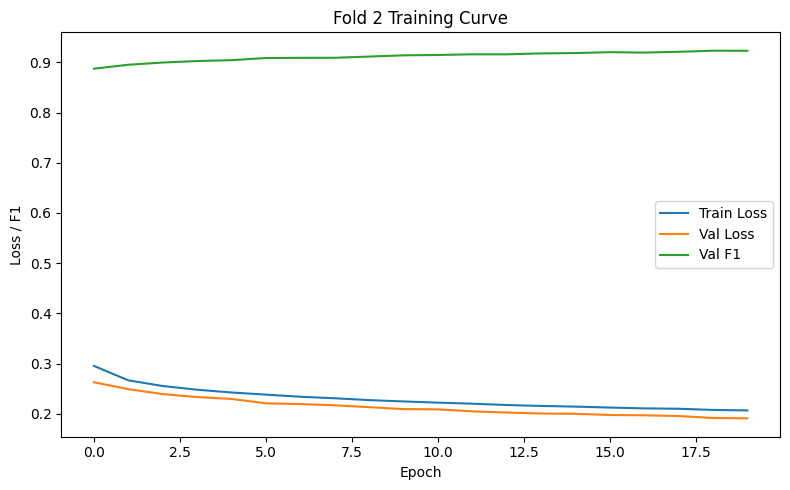

Fold 2 - Accuracy: 0.9221, Precision: 0.9113, Recall: 0.9353, F1: 0.9231
🔹 Avg Accuracy: 0.9218, Precision: 0.9076, Recall: 0.9393, F1: 0.9231

Testing params: hidden_dims=[256, 128, 64], lr=0.0005, dropout=0.2, threshold=0.5


Training Epochs: 100%|██████████| 20/20 [09:33<00:00, 28.68s/it]


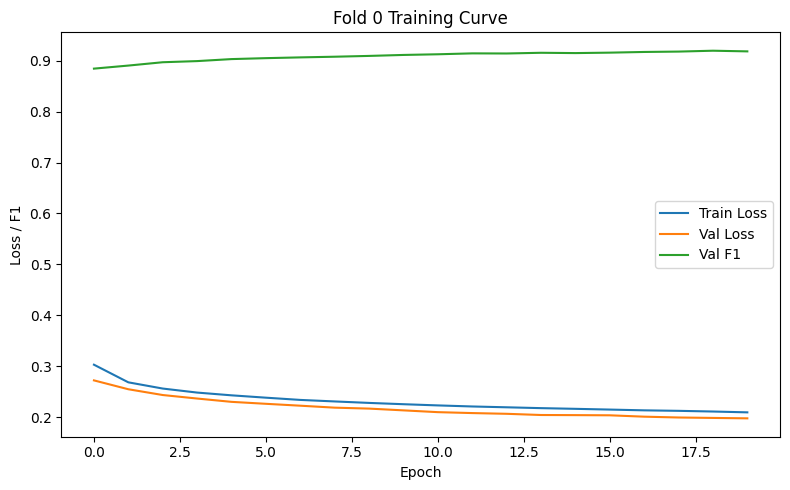

Fold 0 - Accuracy: 0.9176, Precision: 0.9089, Recall: 0.9281, F1: 0.9184


Training Epochs: 100%|██████████| 20/20 [08:51<00:00, 26.58s/it]


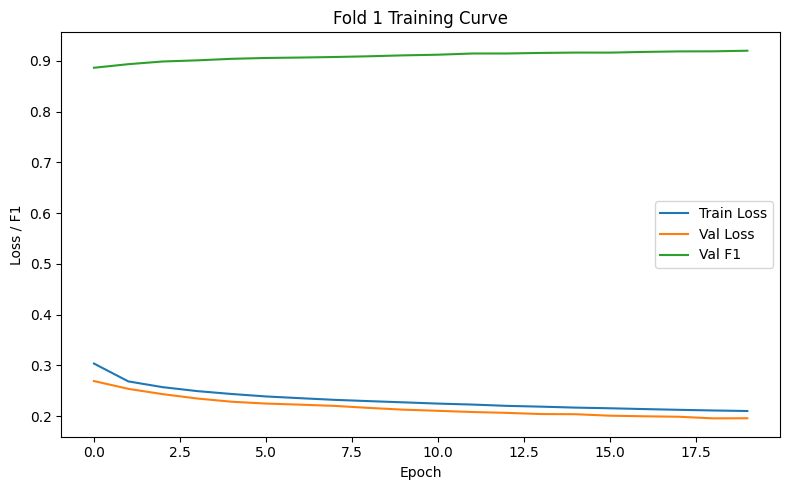

Fold 1 - Accuracy: 0.9187, Precision: 0.9049, Recall: 0.9357, F1: 0.9201


Training Epochs: 100%|██████████| 20/20 [06:49<00:00, 20.47s/it]


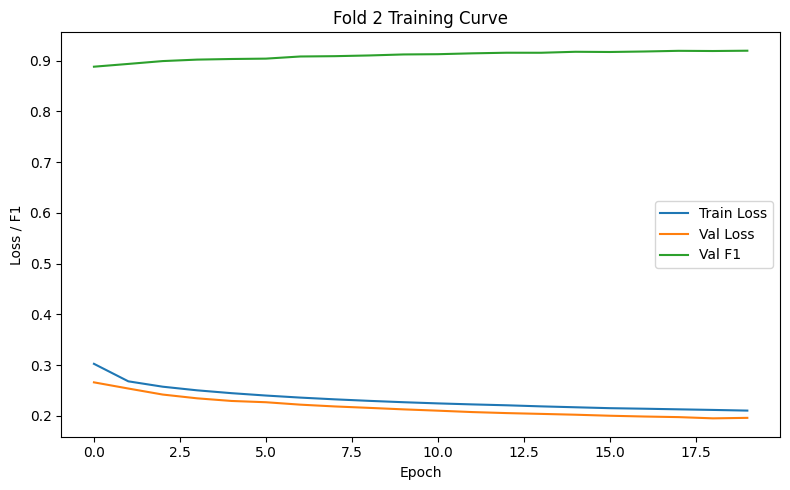

Fold 2 - Accuracy: 0.9188, Precision: 0.9096, Recall: 0.9300, F1: 0.9197
🔹 Avg Accuracy: 0.9183, Precision: 0.9078, Recall: 0.9313, F1: 0.9194

Testing params: hidden_dims=[256, 128, 64], lr=0.0005, dropout=0.3, threshold=0.5


Training Epochs: 100%|██████████| 20/20 [05:29<00:00, 16.45s/it]


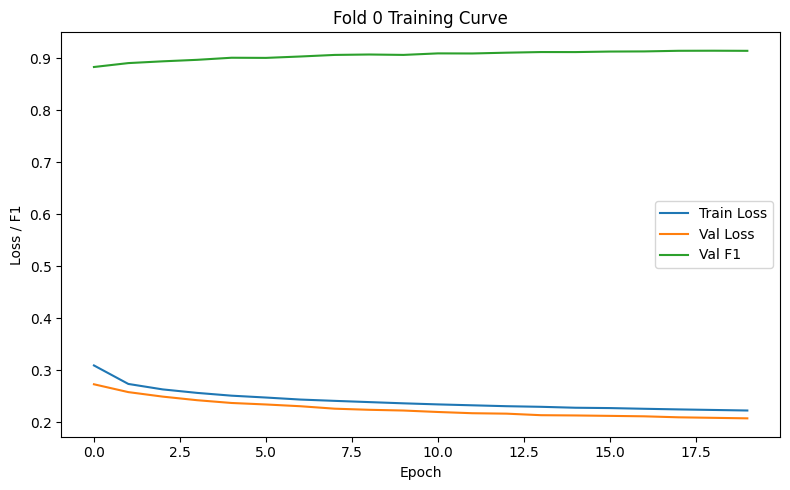

Fold 0 - Accuracy: 0.9126, Precision: 0.8992, Recall: 0.9294, F1: 0.9140


Training Epochs: 100%|██████████| 20/20 [05:30<00:00, 16.51s/it]


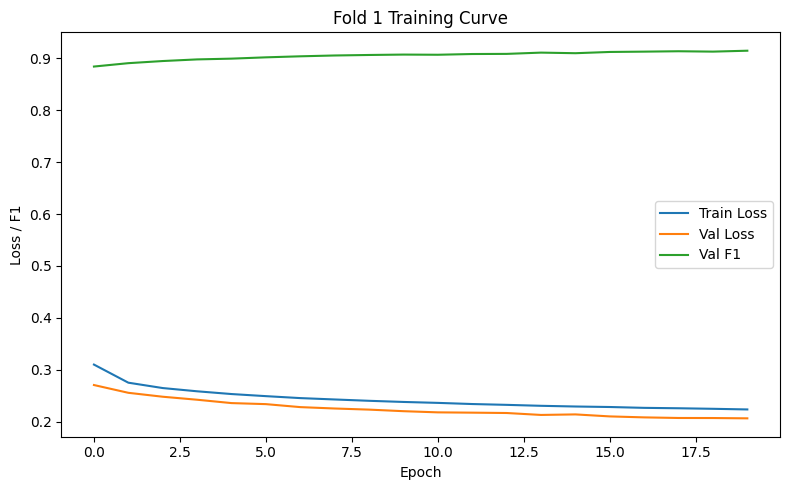

Fold 1 - Accuracy: 0.9130, Precision: 0.8972, Recall: 0.9330, F1: 0.9147


Training Epochs: 100%|██████████| 20/20 [05:28<00:00, 16.43s/it]


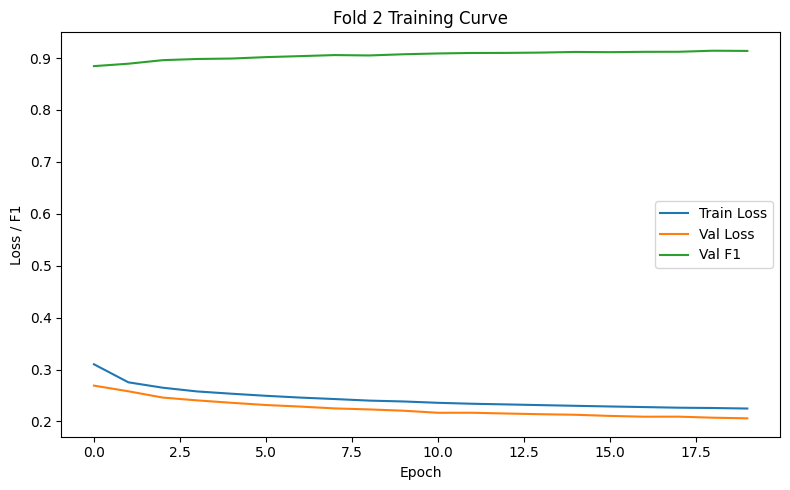

Fold 2 - Accuracy: 0.9125, Precision: 0.9011, Recall: 0.9266, F1: 0.9137
🔹 Avg Accuracy: 0.9127, Precision: 0.8991, Recall: 0.9297, F1: 0.9142


In [12]:
best_params, results = run_random_search(
    X_train_resampled, y_train_resampled,
    param_grid=param_grid,
    k=3,
    epochs=20,
    batch_size=256,
    patience=5,
    device='cpu'
)

In [14]:
best_params

{'hidden_dims': [512, 256], 'lr': 0.001, 'dropout': 0.1}

In [ ]:
best_params= {'hidden_dims': [512, 256], 'lr': 0.001, 'dropout': 0.1}

In [ ]:
train_loader = DataLoader(TensorDataset(X_train_resampled, y_train_resampled), batch_size=256, shuffle=True)

test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=256, shuffle=False)

In [ ]:
model = MLPClassifier(input_dim=X_train_resampled.shape[1], hidden_dims=[512, 256], dropout_rate=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model, logs = train_mlp(
    model=model,
    train_loader=train_loader,
    val_loader=train_loader,
    threshold=0.5,
    epochs=30,
    lr=0.001,
    patience=5,
    device=device,
    return_logs=True
)

Training Epochs: 100%|██████████| 30/30 [22:59<00:00, 45.97s/it]


In [ ]:
# model.eval()
# y_pred_list = []

# with torch.no_grad():
#     for X_batch, _ in test_loader:
#         X_batch = X_batch.to(device)
#         outputs = torch.sigmoid(model(X_batch))
#         preds = (outputs >= 0.5).int().cpu()
#         y_pred_list.append(preds)

# y_pred = torch.cat(y_pred_list).numpy()
# y_true = y_test.numpy()

# print(classification_report(y_true, y_pred, digits=4))

In [ ]:
y_pred_mlp, y_prob_mlp = evaluate_torch_model(model, X_test, y_test, threshold=0.78, model_name="MLP Model")

              precision    recall  f1-score   support

         0.0     0.9783    0.9256    0.9512    176726
         1.0     0.5127    0.7926    0.6227     17466

    accuracy                         0.9136    194192
   macro avg     0.7455    0.8591    0.7869    194192
weighted avg     0.9365    0.9136    0.9217    194192



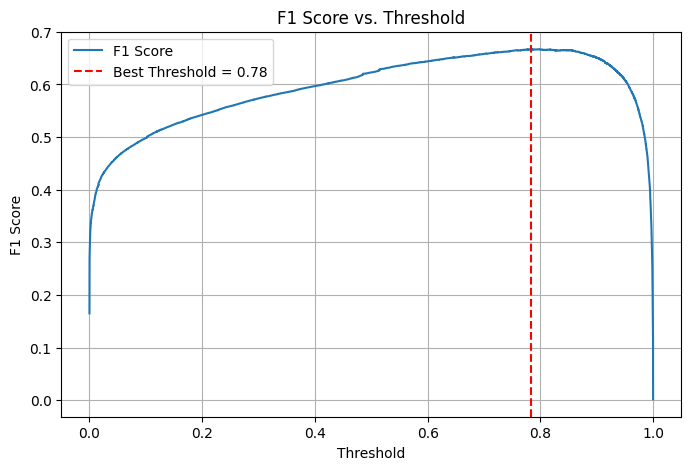

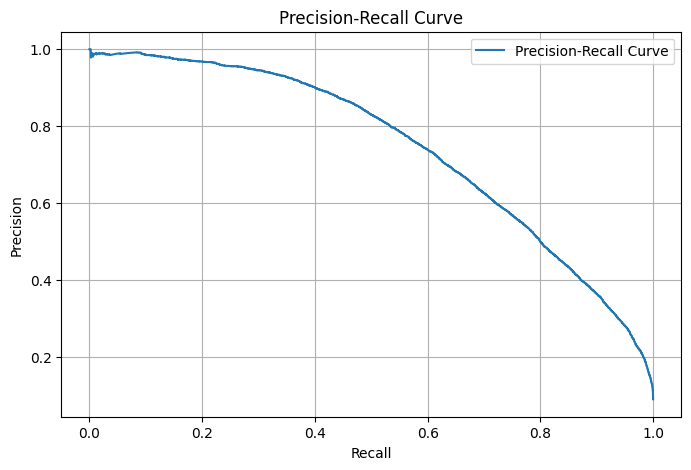

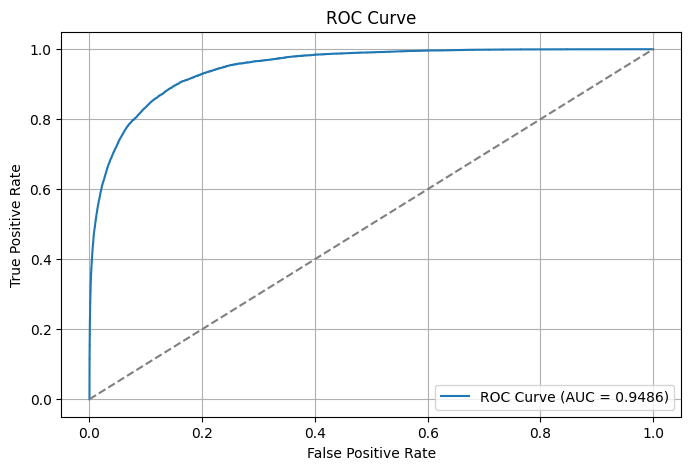

In [ ]:
y_test_array = y_test.numpy() if torch.is_tensor(y_test) else y_test

best_thresh, best_f1 = best_threshold(model, X_test, y_test_array, device=device)
print(f"Best threshold: {best_thresh:.4f}, Best F1 score: {best_f1:.4f}")

In [ ]:
final_model = MLPClassifier(input_dim=X_train_resampled.shape[1], hidden_dims=[512, 256], dropout_rate=0.1)
final_model.to(device)

final_model, logs = train_mlp(
    model=final_model,
    train_loader=train_loader,
    val_loader=train_loader, 
    threshold=0.78,     
    epochs=30,
    lr=0.001,
    patience=5,
    device=device,
    return_logs=True
)

Training Epochs: 100%|██████████| 30/30 [22:42<00:00, 45.41s/it]


In [ ]:
# final_model.eval()
# y_pred_list_final = []

# with torch.no_grad():
#     for X_batch, _ in test_loader:
#         X_batch = X_batch.to(device)
#         outputs = torch.sigmoid(final_model(X_batch))
#         preds = (outputs >= 0.5).int().cpu()
#         y_pred_list_final.append(preds)

# y_pred = torch.cat(y_pred_list_final).numpy()
# y_true = y_test.numpy()

# print(classification_report(y_true, y_pred, digits=4))

In [ ]:
y_pred_mlp, y_prob_mlp = evaluate_torch_model(final_model, X_test, y_test, threshold=0.78, model_name="MLP Model")

              precision    recall  f1-score   support

         0.0     0.9775    0.9280    0.9521    176726
         1.0     0.5182    0.7835    0.6238     17466

    accuracy                         0.9150    194192
   macro avg     0.7478    0.8557    0.7879    194192
weighted avg     0.9362    0.9150    0.9226    194192



In [ ]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
final_model_path = os.path.join(parent_dir, "models","mlp_model.pt")

torch.save(final_model.state_dict(), final_model_path)
print("Model parameters saved as 'mlp_model.pt'")

Model parameters saved as 'mlp_model.pt'


In [29]:
final_model_path = os.path.join(parent_dir, "models","mlp_model.pt")

input_size = 68              
hidden_sizes = [512, 256]    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

final_model = MLPClassifier(input_size, hidden_sizes)
final_model.load_state_dict(torch.load(final_model_path))
final_model.to(device)
final_model.eval()

MLPClassifier(
  (model): Sequential(
    (0): Linear(in_features=68, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)

Semi-Supervised Learning

In [ ]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
unlabeled_path = os.path.join(parent_dir, "data", "data_final","unlabeled_data.csv")
unlabeled_data = pd.read_csv(unlabeled_path)

X_unlabeled = data_preprocessing(unlabeled_data, is_train=False, scaler=scaler, label_encoders=fitted_label_encoders)

In [ ]:
final_model.eval()

with torch.no_grad():
    probs_unlabeled = torch.sigmoid(final_model(X_unlabeled)).cpu().numpy().flatten()

pseudo_labels = (probs_unlabeled >= 0.9).astype(int)

pseudo_labels = torch.tensor(pseudo_labels, dtype=torch.float32)


In [38]:
pseudo_labels = (probs_unlabeled >= 0.95).astype(int)

pseudo_labels = torch.tensor(pseudo_labels, dtype=torch.float32)

X_combined = np.vstack([X_train.numpy(), X_unlabeled.numpy()])

y_combined = np.vstack([y_train.numpy().reshape(-1, 1), pseudo_labels.numpy().reshape(-1, 1)])



In [ ]:
X_combined = torch.tensor(X_combined, dtype=torch.float32)

y_combined = torch.tensor(y_combined, dtype=torch.float32)

X_combined_resampled, y_combined_resampled = data_resampling(X_combined, y_combined)

ssl_loader = DataLoader(TensorDataset(X_combined_resampled, y_combined_resampled), batch_size=256, shuffle=True)

In [ ]:
ssl_model = MLPClassifier(input_dim=X_combined.shape[1], hidden_dims=[512, 256], dropout_rate=0.1).to(device)

ssl_model, ssl_logs = train_mlp(
    model=ssl_model,
    train_loader=ssl_loader,
    val_loader=ssl_loader,
    threshold=0.78,
    epochs=30,
    lr=0.001,
    patience=5,
    device=device,
    return_logs=True
)


Training Epochs: 100%|██████████| 30/30 [1:02:10<00:00, 124.35s/it]


In [ ]:
# ssl_model.eval()
# y_pred_list_ssl = []

# with torch.no_grad():
#     for X_batch, _ in test_loader:
#         X_batch = X_batch.to(device)
#         outputs = torch.sigmoid(ssl_model(X_batch))
#         preds = (outputs >= 0.5).int().cpu()
#         y_pred_list_ssl.append(preds)

# y_pred = torch.cat(y_pred_list_ssl).numpy()
# y_true = y_test.numpy()

# print(classification_report(y_true, y_pred, digits=4))

In [ ]:
y_pred_mlp, y_prob_mlp = evaluate_torch_model(ssl_model, X_test, y_test, threshold=0.78, model_name="MLP Model with Semi-Supervised Learning")

              precision    recall  f1-score   support

         0.0     0.9765    0.9269    0.9511    176726
         1.0     0.5116    0.7746    0.6162     17466

    accuracy                         0.9132    194192
   macro avg     0.7441    0.8508    0.7837    194192
weighted avg     0.9347    0.9132    0.9210    194192



In [45]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
ssl_model_path = os.path.join(parent_dir, "models","mlp_ssl_model.pt")

torch.save(ssl_model.state_dict(), ssl_model_path)
print("Model parameters saved as 'mlp_ssl_model.pt'")

Model parameters saved as 'mlp_ssl_model.pt'
